In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn.models import GraphSAGE, DeepGCNLayer
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [32]:
class GAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_channels):
        super(GAE, self).__init__()
        self.sage = GraphSAGE(input_dim, hidden_dim, num_layers=num_layers, out_channels=out_channels, dropout=0.5)
        self.lin1 = Linear(out_channels, out_channels)
        self.lin2 = Linear(out_channels, out_channels)
        self.lin3 = Linear(out_channels, out_channels)
        self.lin4 = Linear(out_channels, out_channels)
        self.lin = Linear(out_channels, 2)

    def forward(self, data, batch=None):
        x, edge_index, pos = data.x, data.edge_index, data.pos
        edge_weight = calculate_edge_weights(pos, edge_index)
        x = self.sage(x, edge_index, edge_weight)
        y = F.relu(self.lin1(global_mean_pool(x, batch)))
        y1 = F.relu(self.lin2(y))
        y2 = F.relu(self.lin3(y1))
        y3 = F.relu(self.lin4(y2)) + y1         
        y = self.lin(y3)
        return y

# Calculate Euclidean distances as edge weights
def calculate_edge_weights(pos, edge_index):
    row, col = edge_index
    distances = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return distances


In [53]:
train_loader = torch.load(r'C:\Users\Rohit\Documents\Projects\data\MLgSA\train_loader.pt')
test_loader = torch.load(r'C:\Users\Rohit\Documents\Projects\data\MLgSA\test_loader.pt')

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on: ', device)

Running on:  cuda


In [95]:
model = GAE(input_dim=1, hidden_dim=16, num_layers=1, out_channels=16).to(device)

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=.1, end_factor=1e-4, total_iters=100)
train_losses = []
test_losses = []
test_accu = []

In [97]:
for epoch in range(1, 100 + 1):
        # Train Phase
        run_loss = 0.
        iters = 0
        model.train()
        eval_loss = 0.
        for graph in train_loader:
            graph.to(device)
            optimizer.zero_grad()
            out = model(graph)
            loss = loss_fn(out, graph.y)
            loss.backward()
            #for name, param in model.named_parameters():
            #    print(name, param.grad)
            optimizer.step()
            
            run_loss += loss.item()
            iters += 1
        train_losses.append(run_loss/iters)


        # Eval Phase
        eval_iters = 0
        model.eval()
        accs = []
        for graph in test_loader:
            graph.to(device)
            out = model(graph)
            loss = loss_fn(out, graph.y)
            eval_loss += loss.item()
            eval_iters += 1
            accs.append((out.argmax()==graph.y).item())
        test_accu.append(np.sum(accs) / len(accs))
        test_losses.append(eval_loss/eval_iters)

        scheduler.step()

        if epoch % 10 == 0: 
            show_info = '\nEpoch: {} -- Train: {}, Loss: {}, \
                Accuracy: {}'.format(epoch, train_losses[-1], test_losses[-1], \
                                    test_accu[-1] )
            print(show_info)



Epoch: 10 -- Train: 0.6632759954248156, Loss: 0.6474594399333,                 Accuracy: 0.625

Epoch: 20 -- Train: 0.6383793196257423, Loss: 0.5886928305029869,                 Accuracy: 0.725

Epoch: 30 -- Train: 0.5094076647978871, Loss: 0.38700721114873887,                 Accuracy: 0.85

Epoch: 40 -- Train: 0.5022783465370411, Loss: 0.3704563150182366,                 Accuracy: 0.825

Epoch: 50 -- Train: 0.4877111157950233, Loss: 0.3750839687883854,                 Accuracy: 0.85

Epoch: 60 -- Train: 0.4895555026390973, Loss: 0.3819905065000057,                 Accuracy: 0.85

Epoch: 70 -- Train: 0.48769958536414537, Loss: 0.3728613121435046,                 Accuracy: 0.875

Epoch: 80 -- Train: 0.4829742038199882, Loss: 0.36799418460577726,                 Accuracy: 0.875

Epoch: 90 -- Train: 0.48280369434036124, Loss: 0.3694021778181195,                 Accuracy: 0.875

Epoch: 100 -- Train: 0.47917509748905646, Loss: 0.36890193074941635,                 Accuracy: 0.875


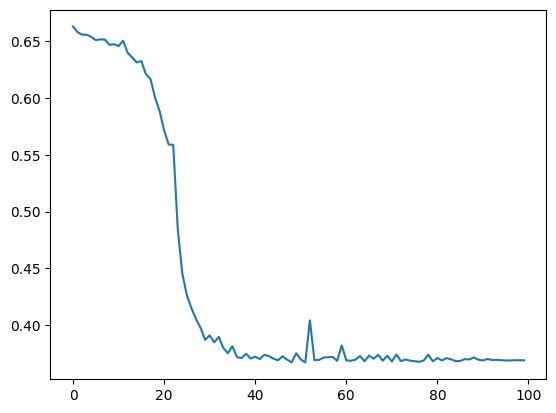

In [98]:
plt.plot(test_losses)

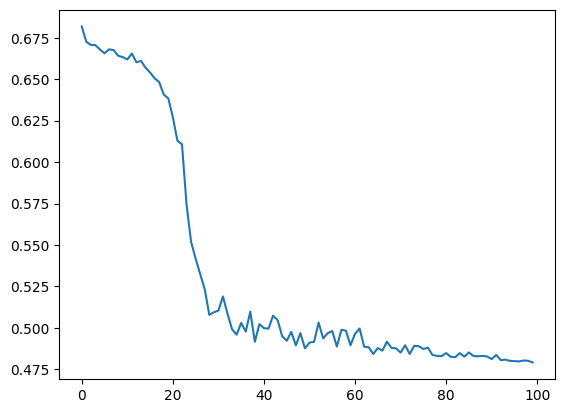

In [99]:
plt.plot(train_losses)

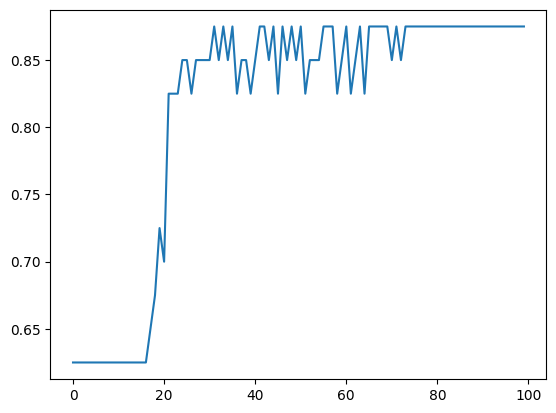

In [100]:
plt.plot(test_accu)

In [101]:
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "./states")

np.savetxt('train_log.npy', np.asarray(train_losses))
np.savetxt('test_log.npy', np.asarray(test_losses))
np.savetxt('accu_log.npy', np.asarray(test_accu))